In [3]:
import numpy as np
import numpy.matlib

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpl_img
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib inline

import seaborn as sns

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.neural_network import MLPClassifier
from scipy.stats import randint

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



import pandas as pd

import statistics
import scipy.io as spio
from scipy.sparse.csgraph import shortest_path
import scipy.sparse.linalg as ll
from scipy import stats
from scipy.stats import multivariate_normal as mvn

# import math
# import random as rand 
# from itertools import product

# from mpl_toolkits.mplot3d import Axes3D

### reading images

In [4]:
tumor = pd.read_csv('data/Brain Tumor.csv')
foFeatures = tumor[['Mean', 'Variance', 'Standard Deviation', 'Skewness', 'Kurtosis']]
foFeatures.describe()
tumor.head()
target = tumor[['Class']]
target.value_counts()

Class
0        2079
1        1683
Name: count, dtype: int64

In [5]:
image_list = []
for i in range(1,3763):
    im = Image.open(f'data/images/Image{i}.jpg').convert('L')
    a,b = im.size
    im2 = im.resize((int(a/2), int(b/2)))
    vector_image = np.array(im2, dtype = 'int32').flatten()
    image_list.append(vector_image)
image = (np.array(image_list))/255

In [6]:
Xtrain, Xtest, ytrain, ytest = train_test_split(image, target.values.ravel(), test_size=0.2, random_state=1)

In [7]:
image_list2 = []
for i in range(1,3763):
    im = Image.open(f'data/images/Image{i}.jpg').convert('L')
    a,b = im.size
    im2 = im.resize((int(a/4), int(b/4)))
    vector_image = np.array(im2, dtype = 'int32').flatten()
    image_list2.append(vector_image)
image2 = (np.array(image_list2))/255

In [8]:
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(image2, target.values.ravel(), test_size=0.2, random_state=1)

### scaled data

In [9]:
#Scaling the features using pipeline
sc = StandardScaler()
scaled_X = sc.fit_transform(image2)

### PCA

In [10]:
##images

P = PCA(n_components = 10)
pca_all = P.fit_transform(scaled_X)

In [11]:
pca_train, pca_test, pca_y_train, pca_y_test = train_test_split(scaled_X, target.values.ravel(), test_size=0.2, random_state=1)

In [12]:
# Normalize the features
feature_names = tumor.columns[2::]
bt_features = tumor.loc[:, feature_names]
bt_feat_df = pd.DataFrame(StandardScaler().fit_transform(bt_features), columns=feature_names) # normalizing the features

bt_feat_df.head()
t4_pca_btumor = PCA(n_components=4) # New PCA object with top four components

principalComponents_btumor = t4_pca_btumor.fit_transform(bt_feat_df) # fit model with top four compenents

### subsets

In [ ]:

elasticnetset = bt_feat_df[['Energy', 'Skewness','Homogeneity', 'Variance', 'Mean']]
pcavarset = bt_feat_df[['Variance', 'Contrast', 'Kurtosis', 'Mean', 'Skewness']]

### Neural Network

In [10]:
clf = MLPClassifier()
clf.fit(scaled_X_train, ytrain2)

MLPClassifier()

In [11]:
print(clf.score(scaled_X_train, ytrain2))
print(clf.score(scaled_X_test, ytest2))

1.0
0.9694555112881806


In [175]:
layer_list = [(40, 35), (30, 20, 15), (40, 35, 20), (20, 25, 15)]

def nnetwork(X, y,type):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    perceptron = MLPClassifier(max_iter=1500)
    parameter_space = {
        'hidden_layer_sizes': layer_list,
        'activation': ['relu', 'tanh'],
        'solver': ['adam'],
        'alpha': np.linspace(0.0001, 0.1, 10),
        'learning_rate': ['adaptive'],
    }
    clf = GridSearchCV(perceptron, parameter_space, n_jobs=-1, cv=5, return_train_score=True)
    clf.fit(x_train, y_train)
    print('Best parameters found:\n', clf.best_params_)
    
    hidden_layer = np.array(clf.cv_results_['param_hidden_layer_sizes'])
    alpha_layer = np.array(clf.cv_results_['param_alpha'])
    accuracy = np.array(clf.cv_results_['mean_test_score'])
    df = pd.DataFrame(clf.cv_results_)[['param_hidden_layer_sizes', 'param_alpha', 'mean_test_score','mean_train_score']]
    
    for i in layer_list:
        b = df[df['param_hidden_layer_sizes']==i].groupby(by=['param_alpha', 'param_hidden_layer_sizes' ], as_index=False).mean()
        plt.plot(b['param_alpha'], b['mean_test_score'], label = i)
        top_score = (max(b['mean_test_score']))
        top = (b[b['mean_test_score'] == top_score]['param_alpha']).mean()
        plt.plot(top, top_score, marker = '.', markersize=15)
        plt.text(top+.001, top_score, f'({round(top,3)}, {round(top_score, 3)})')
    plt.ylabel('Accuracy') 
    plt.xlabel('alpha')
    plt.legend()
    plt.show()
    plt.savefig(f'images/nn-tune-{type}.png')

    ypred_nn = clf.predict(x_test)
    conf_nn = confusion_matrix(y_test, ypred_nn)

    plt.figure(figsize= (8,6))
    sns.heatmap(conf_nn, annot=True, cmap = 'Greens')
    plt.title('Neural Network')
    plt.savefig(f'images/nn-confusion-{type}.png')
    plt.show()

    NN_classificationreport = pd.DataFrame(classification_report(y_test, ypred_nn, output_dict = True)).transpose()
    print(NN_classificationreport.to_latex())
    return df


In [177]:
scaled_X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [79]:
df_scaled[df_scaled['param_alpha']==0.0001]

,param_hidden_layer_sizes,param_alpha,mean_test_score,mean_train_score
0,"(40, 35)",0.0001,0.949482,0.998338
1,"(30, 20, 15)",0.0001,0.940501,0.994269
2,"(40, 35, 20)",0.0001,0.938513,0.993020
3,"(20, 25, 15)",0.0001,0.941841,0.998754
40,"(40, 35)",0.0001,0.926223,0.996760
41,"(30, 20, 15)",0.0001,0.918911,0.990445
42,"(40, 35, 20)",0.0001,0.922564,0.997591
43,"(20, 25, 15)",0.0001,0.915919,0.991776


Best parameters found:
 {'activation': 'relu', 'alpha': 0.0223, 'hidden_layer_sizes': (40, 35), 'learning_rate': 'adaptive', 'solver': 'adam'}


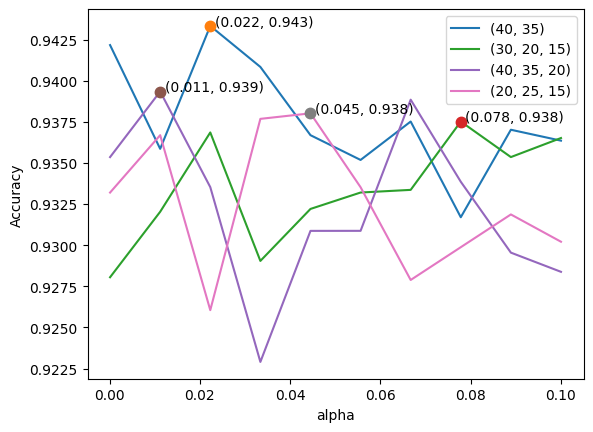

<Figure size 640x480 with 0 Axes>

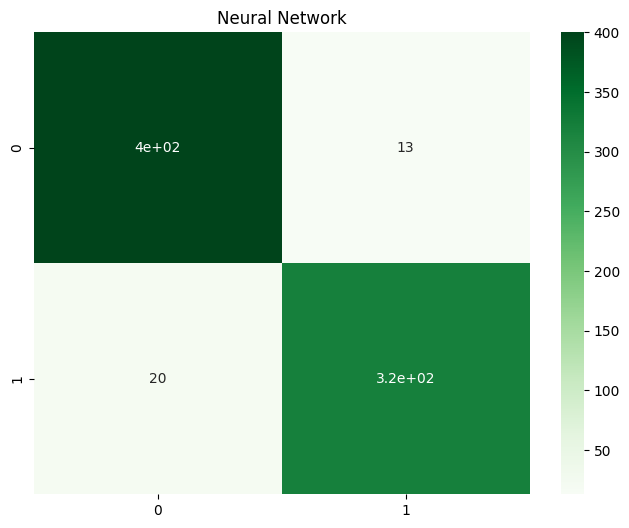

\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
0 & 0.952381 & 0.968523 & 0.960384 & 413.000000 \\
1 & 0.960961 & 0.941176 & 0.950966 & 340.000000 \\
accuracy & 0.956175 & 0.956175 & 0.956175 & 0.956175 \\
macro avg & 0.956671 & 0.954850 & 0.955675 & 753.000000 \\
weighted avg & 0.956255 & 0.956175 & 0.956132 & 753.000000 \\
\bottomrule
\end{tabular}



In [183]:
df_scaled = nnetwork(np.concatenate([scaled_X_train, scaled_X_test]), np.concatenate([ytrain2, ytest2]),'image-s')

In [80]:
df_pca[df_pca['param_alpha']==0.07780000000000001]

,param_hidden_layer_sizes,param_alpha,mean_test_score,mean_train_score
28,"(40, 35)",0.0778,0.893314,0.930541
29,"(30, 20, 15)",0.0778,0.899626,0.935028
30,"(40, 35, 20)",0.0778,0.906271,0.945663
31,"(20, 25, 15)",0.0778,0.891652,0.928547
68,"(40, 35)",0.0778,0.892318,0.941259
69,"(30, 20, 15)",0.0778,0.880022,0.947658
70,"(40, 35, 20)",0.0778,0.883347,0.952642
71,"(20, 25, 15)",0.0778,0.875705,0.926802


Best parameters found:
 {'activation': 'relu', 'alpha': 0.055600000000000004, 'hidden_layer_sizes': (40, 35, 20), 'learning_rate': 'adaptive', 'solver': 'adam'}


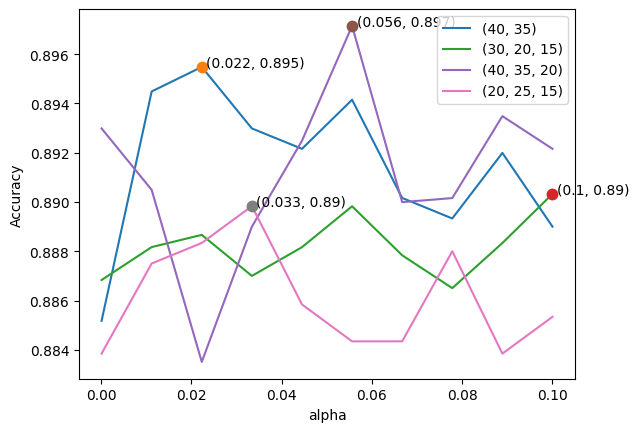

<Figure size 640x480 with 0 Axes>

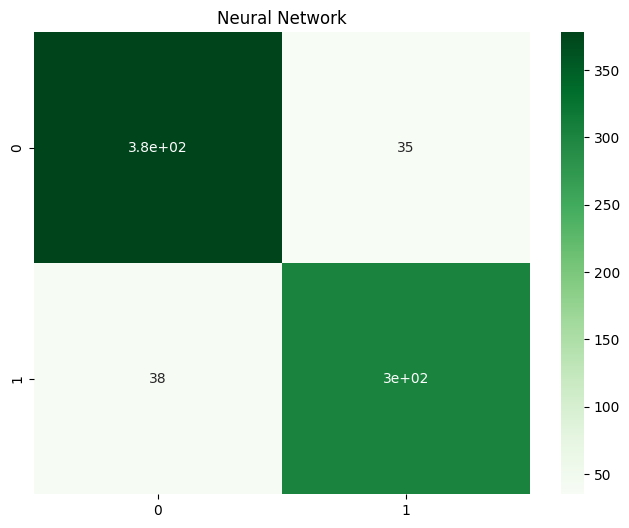

\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
0 & 0.908654 & 0.915254 & 0.911942 & 413.000000 \\
1 & 0.896142 & 0.888235 & 0.892171 & 340.000000 \\
accuracy & 0.903054 & 0.903054 & 0.903054 & 0.903054 \\
macro avg & 0.902398 & 0.901745 & 0.902057 & 753.000000 \\
weighted avg & 0.903005 & 0.903054 & 0.903015 & 753.000000 \\
\bottomrule
\end{tabular}



In [184]:
df_pca = nnetwork(np.concatenate([pca_train, pca_test]), np.concatenate([ytrain2, ytest2]),'image-pca')

In [71]:
y_target=target.values.ravel()


In [82]:
print(df_pca_var[df_pca_var['param_alpha']==0.033400000000000006])
print(df_pca_4[df_pca_4['param_alpha']==0.06670000000000001])

   param_hidden_layer_sizes param_alpha  mean_test_score  mean_train_score
12                 (40, 35)      0.0334         0.946163          0.954304
13             (30, 20, 15)      0.0334         0.953475          0.958375
14             (40, 35, 20)      0.0334         0.949817          0.962945
15             (20, 25, 15)      0.0334         0.945832          0.949735
52                 (40, 35)      0.0334         0.942174          0.947740
53             (30, 20, 15)      0.0334         0.941179          0.943668
54             (40, 35, 20)      0.0334         0.933532          0.941675
55             (20, 25, 15)      0.0334         0.941508          0.944085
   param_hidden_layer_sizes param_alpha  mean_test_score  mean_train_score
24                 (40, 35)      0.0667         0.975741          0.977484
25             (30, 20, 15)      0.0667         0.978399          0.978481
26             (40, 35, 20)      0.0667         0.976073          0.978564
27             (20, 25, 1

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0112, 'hidden_layer_sizes': (20, 25, 15), 'learning_rate': 'adaptive', 'solver': 'adam'}


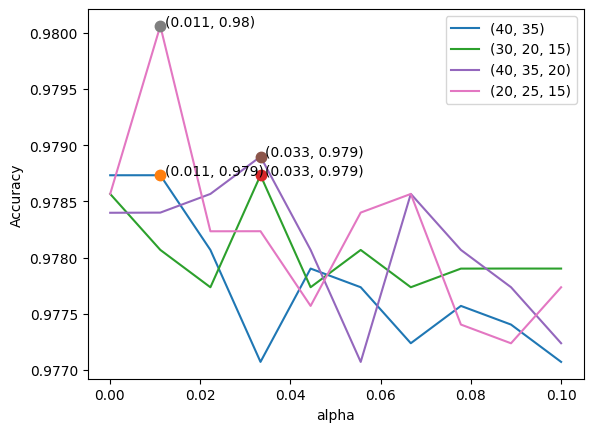

<Figure size 640x480 with 0 Axes>

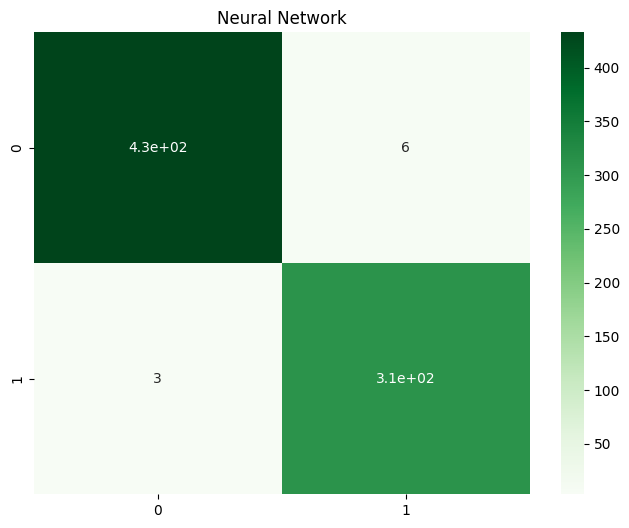

\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
0 & 0.993119 & 0.986333 & 0.989714 & 439.000000 \\
1 & 0.981073 & 0.990446 & 0.985737 & 314.000000 \\
accuracy & 0.988048 & 0.988048 & 0.988048 & 0.988048 \\
macro avg & 0.987096 & 0.988389 & 0.987726 & 753.000000 \\
weighted avg & 0.988096 & 0.988048 & 0.988056 & 753.000000 \\
\bottomrule
\end{tabular}

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (40, 35, 20), 'learning_rate': 'adaptive', 'solver': 'adam'}


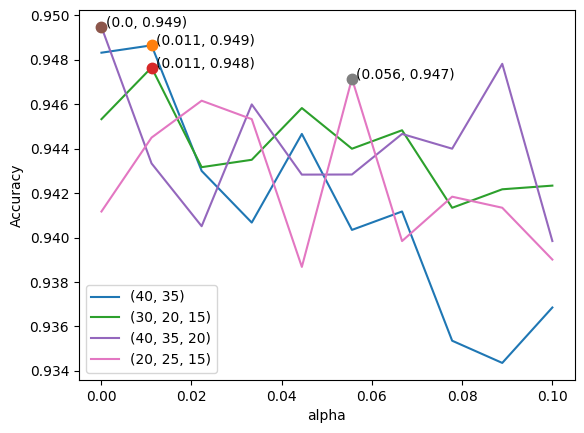

<Figure size 640x480 with 0 Axes>

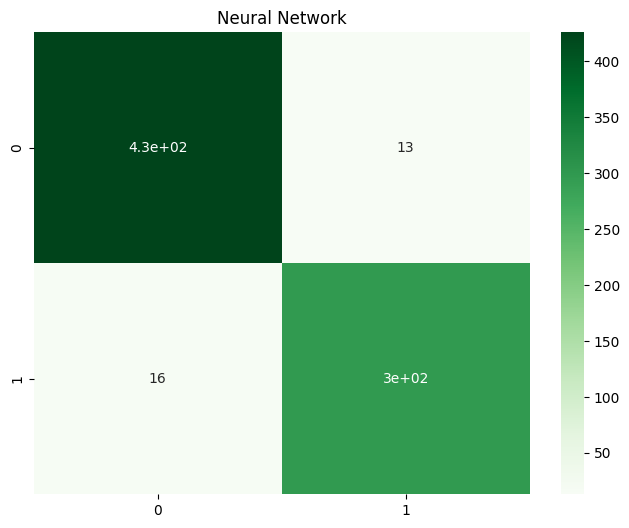

\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
0 & 0.963801 & 0.970387 & 0.967083 & 439.000000 \\
1 & 0.958199 & 0.949045 & 0.953600 & 314.000000 \\
accuracy & 0.961487 & 0.961487 & 0.961487 & 0.961487 \\
macro avg & 0.961000 & 0.959716 & 0.960341 & 753.000000 \\
weighted avg & 0.961465 & 0.961487 & 0.961461 & 753.000000 \\
\bottomrule
\end{tabular}

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0223, 'hidden_layer_sizes': (20, 25, 15), 'learning_rate': 'adaptive', 'solver': 'adam'}


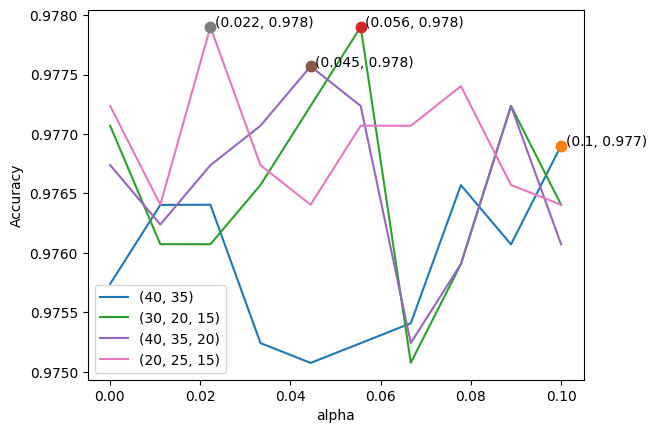

<Figure size 640x480 with 0 Axes>

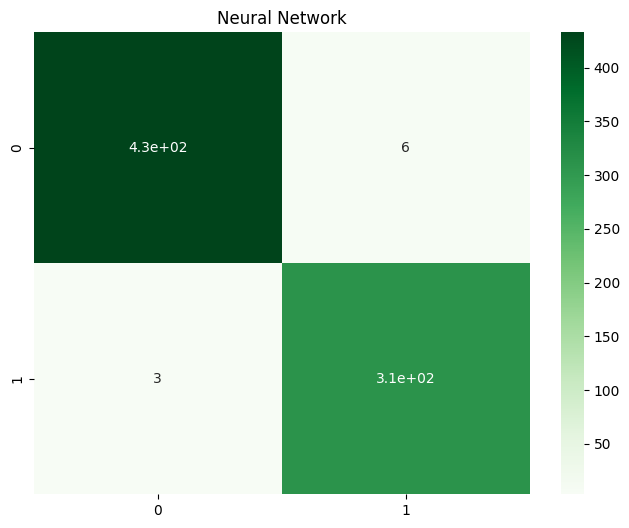

\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
0 & 0.993119 & 0.986333 & 0.989714 & 439.000000 \\
1 & 0.981073 & 0.990446 & 0.985737 & 314.000000 \\
accuracy & 0.988048 & 0.988048 & 0.988048 & 0.988048 \\
macro avg & 0.987096 & 0.988389 & 0.987726 & 753.000000 \\
weighted avg & 0.988096 & 0.988048 & 0.988056 & 753.000000 \\
\bottomrule
\end{tabular}



In [185]:
df_en = nnetwork(elasticnetset,y_target,'en')
df_pca_var = nnetwork(pcavarset,y_target,'pcavar')
df_pca_4 = nnetwork(principalComponents_btumor, y_target, 'pca4')

,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image2,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image3,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image5,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155


In [13]:
clf.fit(scaled_X_train, ytrain2)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1500), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': array([0.0001, 0.0112, 0.0223, 0.0334, 0.0445, 0.0556, 0.0667, 0.0778,
       0.0889, 0.1   ]),
                         'hidden_layer_sizes': [(40, 35), (30, 20, 15),
                                                (40, 35, 20), (20, 25, 15)],
                         'learning_rate': ['adaptive'], 'solver': ['adam']})

In [14]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0223, 'hidden_layer_sizes': (40, 35), 'learning_rate': 'adaptive', 'solver': 'adam'}


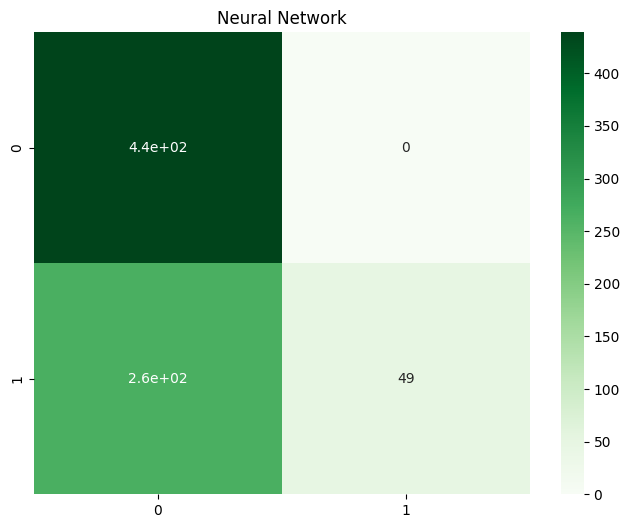

\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
0 & 0.623580 & 1.000000 & 0.768154 & 439.000000 \\
1 & 1.000000 & 0.156051 & 0.269972 & 314.000000 \\
accuracy & 0.648074 & 0.648074 & 0.648074 & 0.648074 \\
macro avg & 0.811790 & 0.578025 & 0.519063 & 753.000000 \\
weighted avg & 0.780546 & 0.648074 & 0.560413 & 753.000000 \\
\bottomrule
\end{tabular}



In [17]:
ypred_nn = clf.predict(Xtest2)
conf_nn = confusion_matrix(ytest2, ypred_nn)

plt.figure(figsize= (8,6))
sns.heatmap(conf_nn, annot=True, cmap = 'Greens')
plt.title('Neural Network')
plt.savefig('images/svmK-confusion.png')
plt.show()

NN_classificationreport = pd.DataFrame(classification_report(ytest, ypred_nn, output_dict = True)).transpose()
print(NN_classificationreport.to_latex())

In [18]:
hidden_layer = np.array(clf.cv_results_['param_hidden_layer_sizes'])
alpha_layer = np.array(clf.cv_results_['param_alpha'])
accuracy = np.array(clf.cv_results_['mean_test_score'])
df = pd.DataFrame(clf.cv_results_)[['param_hidden_layer_sizes', 'param_alpha', 'mean_test_score']]

In [19]:
layer_list = [(40, 35), (30, 20, 15), (40, 35, 20), (20, 25, 15)]

C:\Users\hanna\AppData\Local\Temp\ipykernel_35352\1581275193.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  top = float(b[b['mean_test_score'] == top_score]['param_alpha'])
C:\Users\hanna\AppData\Local\Temp\ipykernel_35352\1581275193.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  top = float(b[b['mean_test_score'] == top_score]['param_alpha'])
C:\Users\hanna\AppData\Local\Temp\ipykernel_35352\1581275193.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  top = float(b[b['mean_test_score'] == top_score]['param_alpha'])
C:\Users\hanna\AppData\Local\Temp\ipykernel_35352\1581275193.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in th

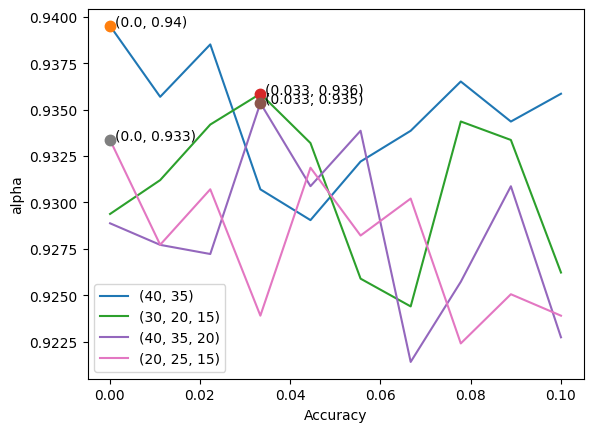

In [22]:
for i in layer_list:
    b = df[df['param_hidden_layer_sizes']==i].groupby(by=['param_alpha', 'param_hidden_layer_sizes' ], as_index=False).mean()
    plt.plot(b['param_alpha'], b['mean_test_score'], label = i)
    top_score = (max(b['mean_test_score']))
    top = float(b[b['mean_test_score'] == top_score]['param_alpha'])
    plt.plot(top, top_score, marker = '.', markersize=15)
    plt.text(top+.001, top_score, f'({round(top,3)}, {round(top_score, 3)})')
plt.ylabel('alpha') 
plt.xlabel('Accuracy')
plt.legend()
plt.show()

In [264]:
def nn_result(model, alphas, layer, name):
    Xtrain, Xtest, ytrain,ytest = train_test_split(model, np.array(target).ravel(), test_size =.2, random_state=1)
    perceptron = MLPClassifier(hidden_layer_sizes = layer, alpha = alphas, max_iter=1500, learning_rate='adaptive').fit(Xtrain, ytrain)
    
    ypred_nn = perceptron.predict(Xtest)
    
    conf_nn = confusion_matrix(ypred_nn, ytest)

    plt.figure(figsize= (8,6))
    sns.heatmap(conf_nn, annot=True, cmap = 'Greens')
    plt.title(f'NN Confusion Matrix - {name}')
    plt.savefig(f'images/nn-confusion-{name}.png')
    plt.show()

    NN_classificationreport = pd.DataFrame(classification_report(ytest, ypred_nn, output_dict = True)).transpose()
    return NN_classificationreport, (NN_classificationreport.to_latex())

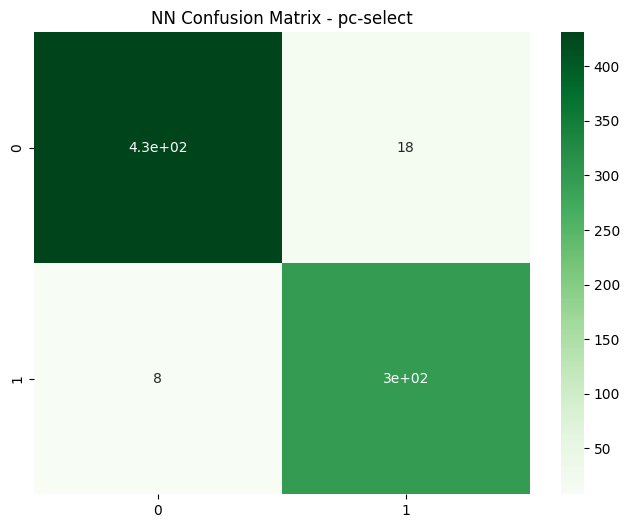

(              precision    recall  f1-score     support
 0              0.959911  0.981777  0.970721  439.000000
 1              0.973684  0.942675  0.957929  314.000000
 accuracy       0.965471  0.965471  0.965471    0.965471
 macro avg      0.966798  0.962226  0.964325  753.000000
 weighted avg   0.965654  0.965471  0.965387  753.000000,
 '\\begin{tabular}{lrrrr}\n\\toprule\n & precision & recall & f1-score & support \\\\\n\\midrule\n0 & 0.959911 & 0.981777 & 0.970721 & 439.000000 \\\\\n1 & 0.973684 & 0.942675 & 0.957929 & 314.000000 \\\\\naccuracy & 0.965471 & 0.965471 & 0.965471 & 0.965471 \\\\\nmacro avg & 0.966798 & 0.962226 & 0.964325 & 753.000000 \\\\\nweighted avg & 0.965654 & 0.965471 & 0.965387 & 753.000000 \\\\\n\\bottomrule\n\\end{tabular}\n')

In [272]:
nn_result(pcavarset, .0667, (30,20,15), 'pc-select')

## SVM

In [112]:
param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['linear','rbf']}

def svc_results(X_train,X_test,y_train,y_test):
    model=GridSearchCV(SVC(),param_grid, return_train_score=True)
    #X_train, X_test, y_train, y_test = train_test_split(X, yset, test_size=0.25)
    model.fit(X_train,y_train)
    result = model.cv_results_.copy()
    predictions = model.predict(X_test)
    reportraw =  classification_report(y_test, predictions, digits=4, output_dict=True)
    report = pd.DataFrame(reportraw).T
    return result, report, model.best_params_

In [247]:
def svm_print(res_raw, kernel, name):
    
    raw = pd.DataFrame(res_raw)
    a = raw[raw['param_kernel']== kernel]

    b = a[['param_C', 'param_gamma', 'mean_test_score', 'mean_train_score']]
    c = b.groupby(by=['param_C']).mean()
    d = b.groupby(by=['param_gamma']).mean()
    e = b.groupby(by=['param_C','param_gamma']).mean()
    #print(e.to_latex())

    gamma_list = [0.0001,0.001,0.1,1]
    df = b
    
    for i in gamma_list:
        f = df[df['param_gamma']==i].groupby(by=['param_C', 'param_gamma' ], as_index=False).mean()
        plt.plot(f['param_C'], f['mean_test_score'], label = i)
        top_score = (max(f['mean_test_score']))
        print(top_score)
        top = float(f[f['mean_test_score'] == top_score]['param_C'].mean())
        plt.plot(top, top_score, marker = '.', markersize=15)
        plt.text(top+.001, top_score, f'({round(top,3)}, {round(top_score, 3)})')
    plt.ylabel('Accuracy') 
    plt.xlabel('C')
    plt.xscale('log')
    plt.legend()
    plt.savefig(f"images\svm-tune-{name}.png")
    plt.show()
    return(b)

In [113]:
img_result, img_report, img_params = svc_results(scaled_X_train,scaled_X_test, ytrain2, ytest2)

In [120]:
pca4_X_train, pca4_X_test, pca4_ytrain, pca4_ytest = train_test_split(principalComponents_btumor, y_target, test_size=0.25)
en_X_train, en_X_test, en_ytrain, en_ytest = train_test_split(elasticnetset, y_target, test_size=0.25)
pcav_X_train, pcav_X_test, pcav_ytrain, pcav_ytest = train_test_split(pcavarset, y_target, test_size=0.25)

In [121]:
img_pca_result, img_pca_report, img_pca_params = svc_results(pca_train,pca_test, ytrain2, ytest2)
pca4_result, pca4_report, pca4_params = svc_results(pca4_X_train, pca4_X_test, pca4_ytrain, pca4_ytest)
en_result, en_report, en_params = svc_results(en_X_train, en_X_test, en_ytrain, en_ytest)
pcav_result, pcav_report, pcav_params = svc_results(pcav_X_train, pcav_X_test, pcav_ytrain, pcav_ytest)

In [282]:
pd.DataFrame(en_result)[['param_C', 'param_gamma','mean_train_score','mean_test_score' ]].sort_values(by='mean_train_score', ascending = False)

,param_C,param_gamma,mean_train_score,mean_test_score
31,100,1,0.986352,0.975539
23,10,1,0.983960,0.978376
29,100,0.1,0.982099,0.980149
15,1,1,0.981655,0.979795
21,10,0.1,0.981390,0.980149
22,10,1,0.980858,0.980503
20,10,0.1,0.980858,0.980503
18,10,0.001,0.980858,0.980503
16,10,0.0001,0.980858,0.980503
24,100,0.0001,0.980769,0.980503


0.926220418903157
0.950146212569306
0.589232784782837
0.5476896202895507


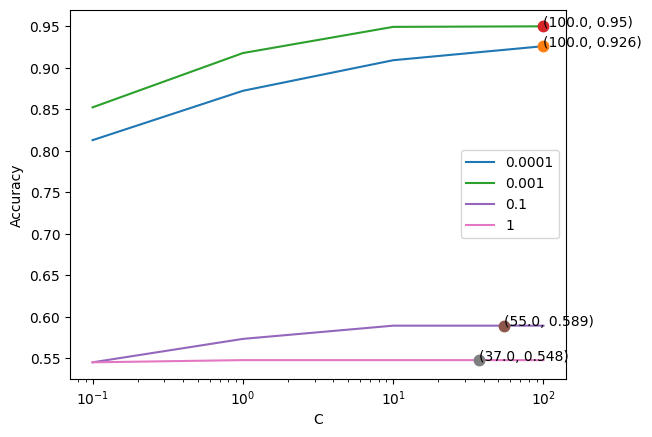

0.8723782621433823
0.9022902029286737
0.8547658664131209
0.5802593683838121


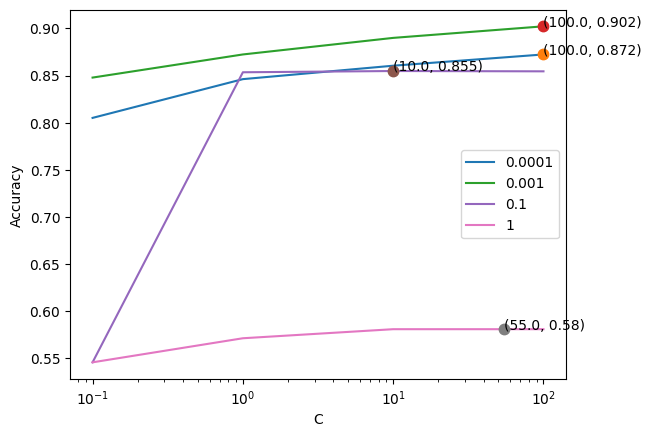

0.9734124144856586
0.9773124960773238
0.9801493755099479
0.9797947655808699


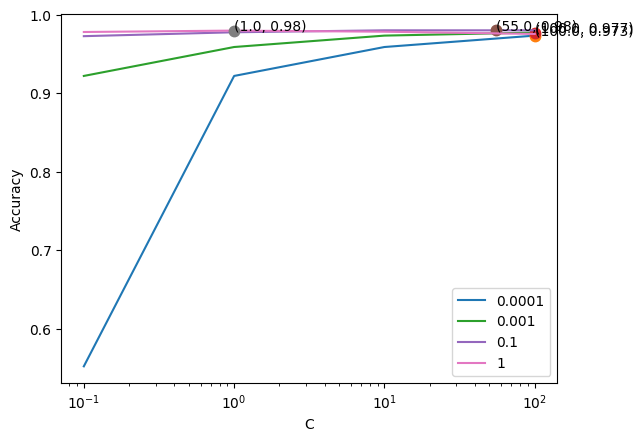

0.8702636038410845
0.8823172032887717
0.956754534613695
0.9563999246846169


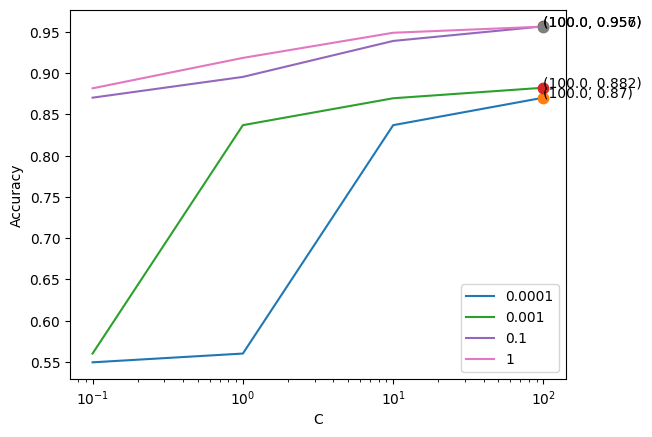

0.9758915458482396
0.9766020209627815
0.9780198330509007
0.9773099855645515


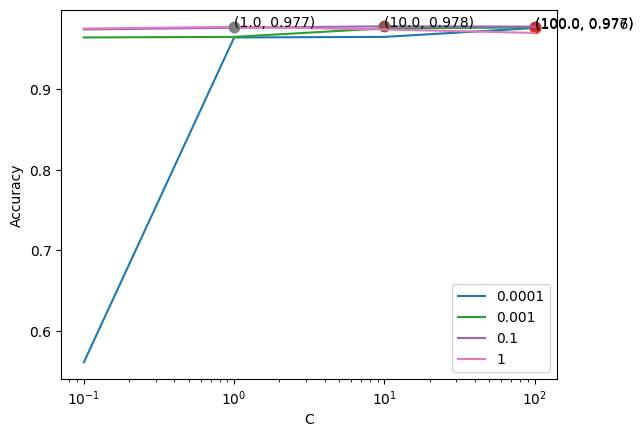

,param_C,param_gamma,mean_test_score,mean_train_score
1,0.1,0.0001,0.560794,0.560794
3,0.1,0.001,0.964194,0.964729
5,0.1,0.1,0.974120,0.974743
7,0.1,1,0.975183,0.977136
9,1,0.0001,0.964194,0.964817
11,1,0.001,0.964904,0.965615
13,1,0.1,0.976247,0.978908
15,1,1,0.977310,0.982896
17,10,0.0001,0.964904,0.965703
19,10,0.001,0.975538,0.975629


In [248]:
svm_print(img_result, 'rbf', 'img')
svm_print(img_pca_result, 'rbf', 'img-pca')
svm_print(en_result, 'rbf', 'en-k')
svm_print(pcav_result, 'rbf', 'pca-var')
svm_print(pca4_result, 'rbf', 'pc')


In [167]:
def predictions(mod_input, xtrainer, xtester, ytrainer, ytester):
    pred_train = model.predict(xtrainer)
    reporttrain =  classification_report(ytrainer, pred_train, digits=4, output_dict=True)
    pred_test = model.predict(xtester)
    reporttest =  classification_report(ytester, pred_test, digits=4, output_dict=True)
    return pd.DataFrame(reporttrain).T, pd.DataFrame(reporttest).T

In [169]:
enfinal = SVC(C=10, gamma=0.0001, kernel='rbf')
enfinal.fit(en_X_train, en_ytrain)

SVC(C=10, gamma=0.0001)

In [174]:
en_pred = enfinal.predict(en_X_test)
rep = classification_report(en_ytest, en_pred, digits=4, output_dict=True)
pd.DataFrame(rep).T

,precision,recall,f1-score,support
0,0.935368,0.998084,0.965709,522.00000
1,0.997396,0.914081,0.953923,419.00000
accuracy,0.960680,0.960680,0.960680,0.96068
macro avg,0.966382,0.956083,0.959816,941.00000
weighted avg,0.962987,0.960680,0.960461,941.00000


In [284]:
def svm_result(model, C1, gamma1, name):
    Xtrain, Xtest, ytrain,ytest = train_test_split(model, np.array(target).ravel(), test_size =.2, random_state=1)
    svk = SVC(C = C1, gamma = gamma1, kernel='rbf').fit(Xtrain, ytrain)
    
    ypred_svk = svk.predict(Xtest)
    
    conf_svk = confusion_matrix(ypred_svk, ytest)

#     plt.figure(figsize= (8,6))
#     sns.heatmap(conf_svk, annot=True, cmap = 'Greens')
#     plt.title(f'SVM-Kernel Confusion Matrix - {name}')
#     plt.savefig(f'images/svmK-confusion-{name}.png')
#     plt.show()

    svk_classificationreport = pd.DataFrame(classification_report(ytest, ypred_svk, output_dict = True)).transpose()
    return svk_classificationreport, (svk_classificationreport.to_latex())

In [286]:
print(svm_result(elasticnetset, 10, 0.0001, 'en-select')[0])
print(svm_result(pcavarset, 100, 0.1, 'pca-select')[0])
print(svm_result(pca_all, 100, 0.001, 'img-pca')[0])
print(svm_result(image2, 1, 0.001, 'img')[0])
print(svm_result(principalComponents_btumor, 10, 0.0001, 'pc')[0])

              precision    recall  f1-score     support
0              0.973392  1.000000  0.986517  439.000000
1              1.000000  0.961783  0.980519  314.000000
accuracy       0.984064  0.984064  0.984064    0.984064
macro avg      0.986696  0.980892  0.983518  753.000000
weighted avg   0.984488  0.984064  0.984016  753.000000
              precision    recall  f1-score     support
0              0.968254  0.972665  0.970455  439.000000
1              0.961538  0.955414  0.958466  314.000000
accuracy       0.965471  0.965471  0.965471    0.965471
macro avg      0.964896  0.964040  0.964460  753.000000
weighted avg   0.965454  0.965471  0.965456  753.000000
              precision    recall  f1-score     support
0              0.938914  0.945330  0.942111  439.000000
1              0.922830  0.914013  0.918400  314.000000
accuracy       0.932271  0.932271  0.932271    0.932271
macro avg      0.930872  0.929672  0.930256  753.000000
weighted avg   0.932207  0.932271  0.932224  753

In [86]:
model=GridSearchCV(SVC(),param_grid)
model.fit(pca_train, ytrain2)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.1, 1],
                         'kernel': ['linear', 'rbf']})

In [110]:
pca_image_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.605994,0.121624,0.021981,0.003901,0.1,0.0001,linear,"{'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}",0.787375,0.769103,0.780731,0.795681,0.803661,0.787310,0.011935,24
1,0.217090,0.049218,0.139739,0.018995,0.1,0.0001,rbf,"{'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}",0.818937,0.774086,0.800664,0.805648,0.825291,0.804925,0.017781,11
2,0.590251,0.053240,0.021881,0.004544,0.1,0.001,linear,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}",0.787375,0.769103,0.780731,0.795681,0.803661,0.787310,0.011935,24
3,0.147792,0.009715,0.091252,0.004689,0.1,0.001,rbf,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.857143,0.840532,0.847176,0.840532,0.853577,0.847792,0.006734,9
4,0.566921,0.014031,0.020552,0.002181,0.1,0.1,linear,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}",0.787375,0.769103,0.780731,0.795681,0.803661,0.787310,0.011935,24
5,0.280117,0.023176,0.192440,0.015786,0.1,0.1,rbf,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}",0.544850,0.544850,0.544850,0.544850,0.545757,0.545032,0.000363,31
6,0.715918,0.072641,0.026288,0.002802,0.1,1,linear,"{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}",0.787375,0.769103,0.780731,0.795681,0.803661,0.787310,0.011935,24
7,0.895140,0.168665,0.476738,0.135777,0.1,1,rbf,"{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}",0.544850,0.544850,0.544850,0.544850,0.545757,0.545032,0.000363,31
8,4.007480,0.879604,0.024269,0.007067,1,0.0001,linear,"{'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}",0.792359,0.769103,0.780731,0.795681,0.801997,0.787974,0.011695,16
9,0.195780,0.053540,0.147474,0.040100,1,0.0001,rbf,"{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}",0.850498,0.837209,0.847176,0.845515,0.850250,0.846130,0.004840,10


In [98]:
pca_image_results = pd.DataFrame(model.cv_results_)
pca_image_results_kernel = pca_image_results[pca_image_results['param_kernel']=='rbf']
pca_image_results_linear = pca_image_results[pca_image_results['param_kernel']=='linear']

\begin{tabular}{llrr}
\toprule
 &  & mean_test_score & std_test_score \\
param_C & param_gamma &  &  \\
\midrule
\multirow[t]{4}{*}{0.100000} & 0.000100 & 0.804925 & 0.017781 \\
 & 0.001000 & 0.847792 & 0.006734 \\
 & 0.100000 & 0.545032 & 0.000363 \\
 & 1.000000 & 0.545032 & 0.000363 \\
\cline{1-4}
\multirow[t]{4}{*}{1.000000} & 0.000100 & 0.846130 & 0.004840 \\
 & 0.001000 & 0.872380 & 0.009105 \\
 & 0.100000 & 0.853439 & 0.006618 \\
 & 1.000000 & 0.570623 & 0.003264 \\
\cline{1-4}
\multirow[t]{4}{*}{10.000000} & 0.000100 & 0.860419 & 0.002781 \\
 & 0.001000 & 0.889994 & 0.010815 \\
 & 0.100000 & 0.854766 & 0.008304 \\
 & 1.000000 & 0.580259 & 0.003989 \\
\cline{1-4}
\multirow[t]{4}{*}{100.000000} & 0.000100 & 0.872378 & 0.010536 \\
 & 0.001000 & 0.902290 & 0.009740 \\
 & 0.100000 & 0.854434 & 0.007893 \\
 & 1.000000 & 0.580259 & 0.003989 \\
\cline{1-4}
\bottomrule
\end{tabular}

0.8723782621433823
0.9022902029286737
0.8547658664131209
0.5802593683838121


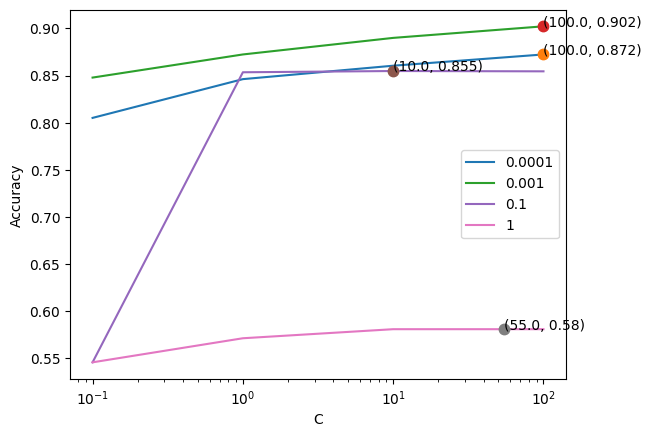

\begin{tabular}{llrr}
\toprule
 &  & mean_test_score & std_test_score \\
param_C & param_gamma &  &  \\
\midrule
\multirow[t]{4}{*}{0.100000} & 0.000100 & 0.787310 & 0.011935 \\
 & 0.001000 & 0.787310 & 0.011935 \\
 & 0.100000 & 0.787310 & 0.011935 \\
 & 1.000000 & 0.787310 & 0.011935 \\
\cline{1-4}
\multirow[t]{4}{*}{1.000000} & 0.000100 & 0.787974 & 0.011695 \\
 & 0.001000 & 0.787974 & 0.011695 \\
 & 0.100000 & 0.787974 & 0.011695 \\
 & 1.000000 & 0.787974 & 0.011695 \\
\cline{1-4}
\multirow[t]{4}{*}{10.000000} & 0.000100 & 0.787975 & 0.011448 \\
 & 0.001000 & 0.787975 & 0.011448 \\
 & 0.100000 & 0.787975 & 0.011448 \\
 & 1.000000 & 0.787975 & 0.011448 \\
\cline{1-4}
\multirow[t]{4}{*}{100.000000} & 0.000100 & 0.787642 & 0.010851 \\
 & 0.001000 & 0.787642 & 0.010851 \\
 & 0.100000 & 0.787642 & 0.010851 \\
 & 1.000000 & 0.787642 & 0.010851 \\
\cline{1-4}
\bottomrule
\end{tabular}

0.7879746380617023
0.7879746380617023
0.7879746380617023
0.7879746380617023


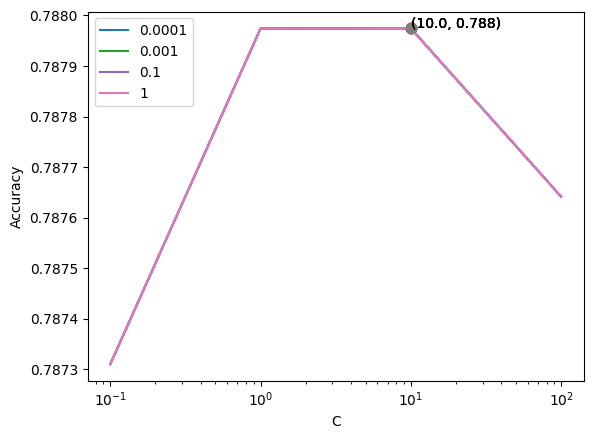

,param_C,param_gamma,mean_test_score,std_test_score
0,0.1,0.0001,0.787310,0.011935
2,0.1,0.001,0.787310,0.011935
4,0.1,0.1,0.787310,0.011935
6,0.1,1,0.787310,0.011935
8,1,0.0001,0.787974,0.011695
10,1,0.001,0.787974,0.011695
12,1,0.1,0.787974,0.011695
14,1,1,0.787974,0.011695
16,10,0.0001,0.787975,0.011448
18,10,0.001,0.787975,0.011448


In [101]:
svm_print(pca_image_results_kernel, 'pca-image-k')
svm_print(pca_image_results_linear, 'pca-image-lin')

In [ ]:
kernelA = r[r['param_kernel']=='rbf']
linearA = r[r['param_kernel']=='linear']

    b = r[['param_C', 'param_gamma', 'mean_test_score', 'std_test_score']]
    c = b.groupby(by=['param_C']).mean()
    d = b.groupby(by=['param_gamma']).mean()
    e = b.groupby(by=['param_C','param_gamma']).mean()
    print(e.to_latex())

In [92]:

result = model.cv_results_.copy()
predictions = model.predict(pca_test)
reportraw =  classification_report(ytest2, predictions, digits=4, output_dict=True)
report = pd.DataFrame(reportraw).T

In [93]:
report

,precision,recall,f1-score,support
0,0.936795,0.945330,0.941043,439.000000
1,0.922581,0.910828,0.916667,314.000000
accuracy,0.930943,0.930943,0.930943,0.930943
macro avg,0.929688,0.928079,0.928855,753.000000
weighted avg,0.930867,0.930943,0.930878,753.000000


## Naive Bayes

In [66]:
def nb_tuning(model, name):

    Xtrain, Xtest, ytrain, ytest = train_test_split(model, target.values.ravel(), test_size = 0.2, )

    param_grid_nb = {'var_smoothing': np.logspace(0,-9,num=100)}

    nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1, return_train_score=True)
    nbModel_grid.fit(Xtrain, ytrain)

    var_smoothing = np.array(nbModel_grid.cv_results_['param_var_smoothing'])
    accuracy = np.array(nbModel_grid.cv_results_['mean_test_score'])
    df = pd.DataFrame(nbModel_grid.cv_results_)[['param_var_smoothing', 'mean_test_score', 'mean_train_score']]

    df.sort_values(by='mean_test_score', ascending=False)

    top_nb_score = (max(df['mean_test_score']))
    top_nb = df[df['mean_test_score']==top_nb_score].groupby(by='mean_test_score', as_index = False).mean()
    top_nb = top_nb['param_var_smoothing'][0]
    plt.plot(top_nb, top_nb_score, marker = '.', markersize=15)
    plt.text(top_nb+.002, top_nb_score, f'({top_nb}, {round(top_nb_score, 3)})')

    plt.plot(var_smoothing, accuracy)
    plt.ylabel('Accuracy')
    plt.xlabel('var_smoothing')
    plt.savefig(f'nb-tuning-{name}.png')
    
    return df


In [71]:
nb_tuning(principalComponents_btumor, 'pc')

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


KeyboardInterrupt: 

In [ ]:
ent = nb_tuning(elasticnetset, 'en-select')
pcvart = nb_tuning(pcvarset, 'pc-select')

In [ ]:
top_nb_score = (max(df['mean_test_score']))
top_nb = df[df['mean_test_score']==top_nb_score].groupby(by='mean_test_score', as_index = False).mean()
top_nb = top_nb['param_var_smoothing'][0]
plt.plot(top_nb, top_nb_score, marker = '.', markersize=15)
plt.text(top_nb+.002, top_nb_score, f'({top_nb}, {round(top_nb_score, 3)})')

plt.plot(var_smoothing, accuracy)
plt.ylabel('Accuracy')
plt.xlabel('var_smoothing')


In [27]:
nbtune = GaussianNB(var_smoothing=0.02310129700083159).fit(Xtrain2,ytrain2)

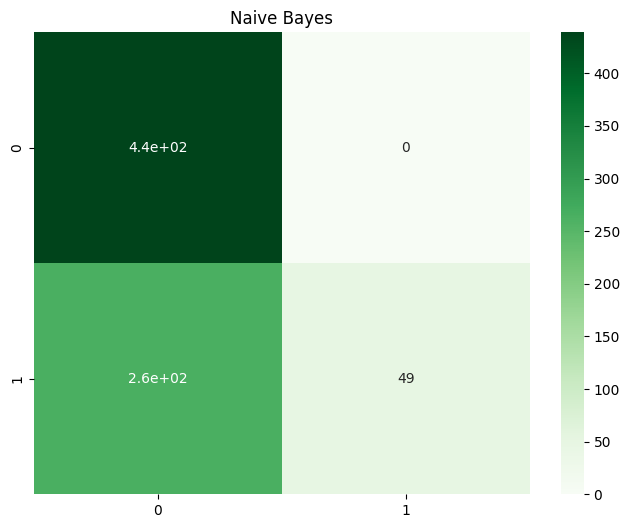

\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
0 & 0.838863 & 0.806378 & 0.822300 & 439.000000 \\
1 & 0.743202 & 0.783439 & 0.762791 & 314.000000 \\
accuracy & 0.796813 & 0.796813 & 0.796813 & 0.796813 \\
macro avg & 0.791032 & 0.794909 & 0.792545 & 753.000000 \\
weighted avg & 0.798972 & 0.796813 & 0.797484 & 753.000000 \\
\bottomrule
\end{tabular}



In [29]:
ypred_nb = nbtune.predict(Xtest2)
conf_nb = confusion_matrix(ytest2, ypred_nb)

plt.figure(figsize= (8,6))
sns.heatmap(conf_nn, annot=True, cmap = 'Greens')
plt.title('Naive Bayes')
plt.savefig('images/NB-confusion.png')
plt.show()

NB_classificationreport = pd.DataFrame(classification_report(ytest, ypred_nb, output_dict = True)).transpose()
print(NB_classificationreport.to_latex())

## KNN

In [238]:
Xtrain, Xtest, ytrain,ytest = train_test_split(elasticnetset, np.array(target).ravel(), test_size =.2, random_state=1)

def knn_tune(modelset, name):
    
    Xtrain, Xtest, ytrain,ytest = train_test_split(modelset, np.array(target).ravel(), test_size =.2, random_state=1)
    testscores = []
    trainscores = []
    k_range = np.arange(2,30,2)

    for i in k_range:
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(Xtrain, ytrain)

        y_pred = knn.predict(Xtest)
        testscores.append(metrics.accuracy_score(ytest, y_pred))    

        y_pred_train = knn.predict(Xtrain)
        trainscores.append(metrics.accuracy_score(ytrain, y_pred_train))    


    ## test acc
    max_test = max(testscores)
    test_spot = testscores.index(max_test)
    test_k = k_range[test_spot]

    ## train acc
    max_train = max(trainscores)
    train_spot = trainscores.index(max_train)
    train_k = k_range[train_spot]
    

    print(max_test, test_k, trainscores[test_spot])


#     plt.figure(figsize=(8, 8))
#     plt.xticks(np.arange(2,30,3))
#     print(testscores)

#     plt.plot(k_range, testscores, color = 'magenta', label = 'test accuracy')
#     plt.plot(k_range, trainscores, color = 'blue', label = 'train accuracy')

#     plt.plot(test_k, max_test, marker = '.', markersize=15, color = 'lightgreen')
#     plt.text(test_k, max_test, f'({test_k}, {round(max_test, 3)})')

#     plt.plot(train_k, max_train, marker = '.', markersize=15, color = 'lightgreen')
#     plt.text(train_k, max_train, f'({train_k}, {round(max_train, 3)})')    


#     plt.xlabel('k neighbors')
#     plt.legend()
#     plt.savefig(f'images/knn-tune-{name}.png')

#     plt.show()
    

In [239]:
knn_tune(elasticnetset, 'en')
knn_tune(pcavarset, 'pcavar')
knn_tune(pca_all, 'pcavimg')
knn_tune(image2, 'rawimage')
knn_tune(principalComponents_btumor, 'pc')

0.9933598937583001 24 0.9750747756729811
0.9123505976095617 2 0.9358590893984713
0.9110225763612217 8 0.9082751744765702
0.9349269588313412 6 0.943502824858757
0.9960159362549801 4 0.9790628115653041


In [252]:
def knn_result(model, k, name):
    Xtrain, Xtest, ytrain,ytest = train_test_split(model, np.array(target).ravel(), test_size =.2, random_state=1)
    knn = KNeighborsClassifier(n_neighbors=k).fit(Xtrain, ytrain)
    
    ypred_knn = knn.predict(Xtest)
    
    conf_knn = confusion_matrix(ypred_knn, ytest)

    plt.figure(figsize= (8,6))
    sns.heatmap(conf_knn, annot=True, cmap = 'Greens')
    plt.title(f'KNN Confusion Matrix - {name}')
    plt.savefig(f'images/knn-confusion-{name}.png')
    plt.show()

    KNN_classificationreport = pd.DataFrame(classification_report(ytest, ypred_knn, output_dict = True)).transpose()
    return KNN_classificationreport, (KNN_classificationreport.to_latex())

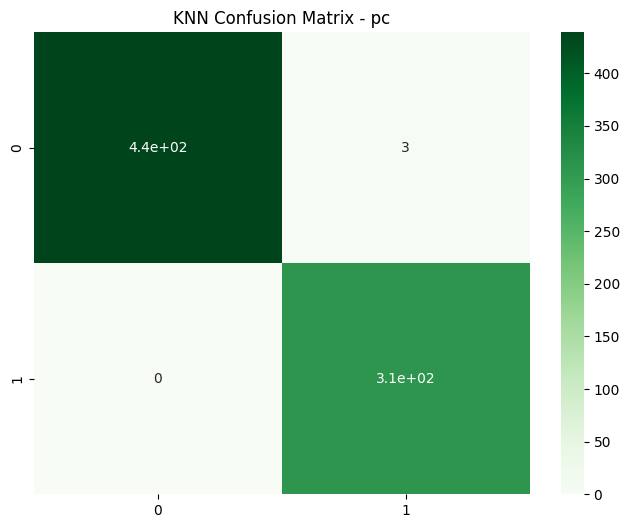

(              precision    recall  f1-score     support
 0              0.993213  1.000000  0.996595  439.000000
 1              1.000000  0.990446  0.995200  314.000000
 accuracy       0.996016  0.996016  0.996016    0.996016
 macro avg      0.996606  0.995223  0.995897  753.000000
 weighted avg   0.996043  0.996016  0.996013  753.000000,
 '\\begin{tabular}{lrrrr}\n\\toprule\n & precision & recall & f1-score & support \\\\\n\\midrule\n0 & 0.993213 & 1.000000 & 0.996595 & 439.000000 \\\\\n1 & 1.000000 & 0.990446 & 0.995200 & 314.000000 \\\\\naccuracy & 0.996016 & 0.996016 & 0.996016 & 0.996016 \\\\\nmacro avg & 0.996606 & 0.995223 & 0.995897 & 753.000000 \\\\\nweighted avg & 0.996043 & 0.996016 & 0.996013 & 753.000000 \\\\\n\\bottomrule\n\\end{tabular}\n')

In [259]:
knn_result(principalComponents_btumor, 4, 'pc')

## Random Forest

In [16]:
full_data = tumor.drop(columns = ['Image', 'Class'])

Xtrain, Xtest, ytrain, ytest = train_test_split(full_data, target.values.ravel(), test_size=.2)

param_grid = {'n_estimators': [100, 200,300, 400, 500],
              'max_depth': np.arange(3,10,1)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
grid_search = GridSearchCV(rf, param_grid = param_grid, 
                                 cv=5, return_train_score=True )
grid_search.fit(Xtrain,ytrain)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': [100, 200, 300, 400, 500]},
             return_train_score=True)

In [18]:
rf_res = pd.DataFrame(grid_search.cv_results_)

In [19]:
small_rf = rf_res[['param_max_depth', 'param_n_estimators', 'mean_test_score', 'mean_train_score']].sort_values(by='mean_test_score', ascending=False)
#print(small_rf[1:10].to_latex(index = False))

In [23]:
small_rf.head()

,param_max_depth,param_n_estimators,mean_test_score,mean_train_score
20,7,100,0.986708,0.994600
34,9,500,0.986376,0.997591
33,9,400,0.986044,0.997508
28,8,400,0.986044,0.996012
31,9,200,0.986044,0.997258


In [54]:
b

,param_max_depth,param_n_estimators,mean_test_score,mean_train_score
0,3,500,0.979730,0.981639
1,4,500,0.982721,0.986457
2,5,500,0.983718,0.989947
3,6,500,0.984715,0.992855
4,7,500,0.984715,0.994766
5,8,500,0.984715,0.996095
6,9,500,0.986376,0.997591


In [58]:


def rftune(model, name):
    df=model
    nest = [100, 200,300, 400, 500]

    for i in nest:
        b = df[df['param_n_estimators']==i].groupby(by=['param_max_depth', 'param_n_estimators' ], as_index=False).mean()
        plt.plot(b['param_max_depth'], b['mean_test_score'], label = i)
        top_score = (max(b['mean_test_score']))
        top = float(b[b['mean_test_score'] == top_score].iloc[0]['param_max_depth'])
        plt.plot(top, top_score, marker = '.', markersize=15)
        plt.text(top+.001, top_score, f'({round(top,3)}, {round(top_score, 3)})')
    plt.ylabel('Accuracy') 
    plt.xlabel('max depth')
    plt.legend()
    plt.savefig(f'images/rf-tune-{name}.png')
    plt.show()

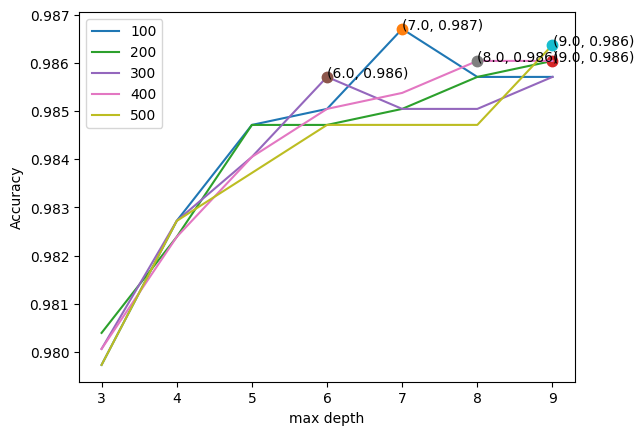

In [59]:
rftune(small_rf, 'feat')

In [ ]:
rf2 = RandomForestClassifier(n_estimators=200, max_depth=8)
rf2.fit(Xtrain,ytrain)

ypred_rf2 = rf2.predict(Xtest)

conf_rf2 = confusion_matrix(ypred_rf2, ytest)

plt.figure(figsize= (8,6))
sns.heatmap(conf_rf2, annot=True, cmap = 'Greens')
plt.title(f'Random Forest Confusion Matrix')
plt.savefig(f'images/RF-confusion.png')
plt.show()

RF_classificationreport = pd.DataFrame(classification_report(ytest, ypred_rf2, output_dict = True)).transpose()
RF_classificationreport

In [17]:
Xtrain, Xtest, ytrain, ytest = train_test_split(image2, target.values.ravel(), test_size=.2)

param_grid2 = {'n_estimators': [100, 200,300, 400, 500],
              'max_depth': np.arange(3,10,1)}

# Create a random forest classifier
rfimg = RandomForestClassifier()

# Use random search to find the best hyperparameters
grid_searchimg = GridSearchCV(rfimg, param_grid = param_grid, 
                                 cv=5, return_train_score=True )
grid_searchimg.fit(Xtrain,ytrain)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': [100, 200, 300, 400, 500]},
             return_train_score=True)

In [20]:
rf_resimg = pd.DataFrame(grid_searchimg.cv_results_)

In [21]:
small_rfimg = rf_resimg[['param_max_depth', 'param_n_estimators', 'mean_test_score', 'mean_train_score']].sort_values(by='mean_test_score', ascending=False)
#print(small_rfimg[1:10].to_latex(index = False))

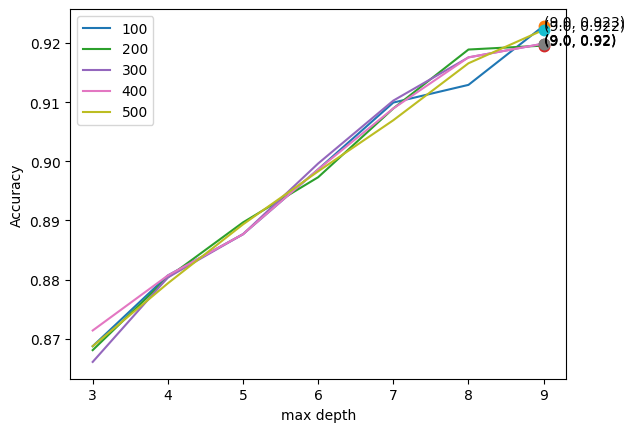

In [60]:
rftune(small_rfimg, 'img')

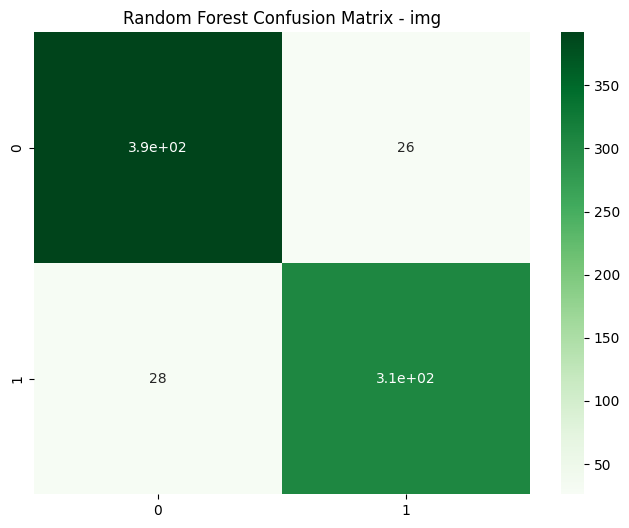

,precision,recall,f1-score,support
0,0.937799,0.933333,0.935561,420.000000
1,0.916418,0.921922,0.919162,333.000000
accuracy,0.928287,0.928287,0.928287,0.928287
macro avg,0.927108,0.927628,0.927361,753.000000
weighted avg,0.928344,0.928287,0.928309,753.000000


In [366]:
rfimg = RandomForestClassifier(n_estimators=200, max_depth=8)
rfimg.fit(Xtrain,ytrain)

ypred_rfimg = rfimg.predict(Xtest)

conf_rfimg = confusion_matrix(ypred_rfimg, ytest)

plt.figure(figsize= (8,6))
sns.heatmap(conf_rfimg, annot=True, cmap = 'Greens')
plt.title(f'Random Forest Confusion Matrix - img')
plt.savefig(f'images/RF-confusion-img.png')
plt.show()

rfimg_classificationreport = pd.DataFrame(classification_report(ytest, ypred_rfimg, output_dict = True)).transpose()
rfimg_classificationreport

## XGBoost

In [354]:
Xtrain, Xtest, ytrain, ytest = train_test_split(full_data, target.values.ravel(), test_size=.2)

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)
folds = 3
param_comb = 20

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)


random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, 
                                   n_jobs=-1, cv=skf.split(Xtrain,ytrain), verbose=3, random_state=1001, return_train_score=True )

random_search.fit(Xtrain, ytrain)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\hanna\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [22:07:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x00000223384493F0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=600, n_jobs=None,
                                           nthread=1, num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=1001, return_train_score=True, verbose=3)

In [356]:
a = pd.DataFrame(random_search.cv_results_)[['param_subsample', 'param_max_depth', 'param_gamma','param_colsample_bytree', 'mean_test_score', 'mean_train_score']].sort_values(by='mean_test_score')
print(a[1:10].to_latex(index=False))

\begin{tabular}{llllrr}
\toprule
param_subsample & param_max_depth & param_gamma & param_colsample_bytree & mean_test_score & mean_train_score \\
\midrule
1.000000 & 3 & 5 & 1.000000 & 0.984048 & 0.988368 \\
0.800000 & 4 & 1.500000 & 0.800000 & 0.984048 & 0.987537 \\
0.800000 & 4 & 1.500000 & 1.000000 & 0.984380 & 0.987371 \\
1.000000 & 5 & 5 & 0.600000 & 0.984380 & 0.988867 \\
1.000000 & 4 & 1.500000 & 0.600000 & 0.984380 & 0.988368 \\
1.000000 & 4 & 1 & 1.000000 & 0.984713 & 0.988701 \\
1.000000 & 3 & 1.500000 & 1.000000 & 0.984713 & 0.988534 \\
0.800000 & 5 & 1 & 0.800000 & 0.985377 & 0.993187 \\
1.000000 & 5 & 0.500000 & 1.000000 & 0.985710 & 0.994018 \\
\bottomrule
\end{tabular}



In [357]:
rf_best = random_search.best_estimator_

C:\Users\hanna\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [22:25:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


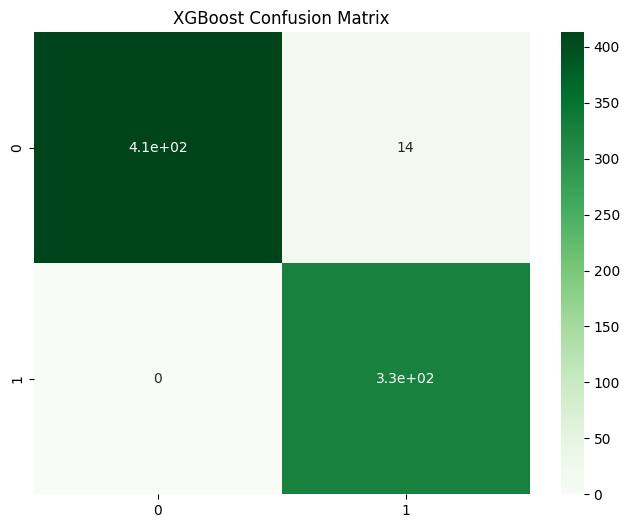

,precision,recall,f1-score,support
0,0.978673,1.000000,0.989222,413.000000
1,1.000000,0.973529,0.986587,340.000000
accuracy,0.988048,0.988048,0.988048,0.988048
macro avg,0.989336,0.986765,0.987904,753.000000
weighted avg,0.988303,0.988048,0.988032,753.000000


In [360]:
xgb2 = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1, subsample=1, max_depth =3, gamma=5, colsample_bytree=1)

xgb2.fit(Xtrain,ytrain)

ypred_xgb2 = xgb2.predict(Xtest)

conf_xgb2 = confusion_matrix(ypred_xgb2, ytest)

plt.figure(figsize= (8,6))
sns.heatmap(conf_xgb2, annot=True, cmap = 'Greens')
plt.title(f'XGBoost Confusion Matrix')
plt.savefig(f'images/xgb-confusion.png')
plt.show()

xgb2_classificationreport = pd.DataFrame(classification_report(ytest, ypred_xgb2, output_dict = True)).transpose()
RF_classificationreport

In [367]:
Xtrain, Xtest, ytrain, ytest = train_test_split(image2, target.values.ravel(), test_size=.2)

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)
folds = 3
param_comb = 20

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)


random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, 
                                   n_jobs=-1, cv=skf.split(Xtrain,ytrain), verbose=3, random_state=1001, return_train_score=True )

random_search.fit(Xtrain, ytrain)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\hanna\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [23:05:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000002235BCC4200>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=600, n_jobs=None,
                                           nthread=1, num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=1001, return_train_score=True, verbose=3)

In [368]:
b = pd.DataFrame(random_search.cv_results_)[['param_subsample', 'param_max_depth', 'param_gamma','param_colsample_bytree', 'mean_test_score', 'mean_train_score']].sort_values(by='mean_test_score')
print(b[1:10].to_latex(index=False))

\begin{tabular}{llllrr}
\toprule
param_subsample & param_max_depth & param_gamma & param_colsample_bytree & mean_test_score & mean_train_score \\
\midrule
1.000000 & 5 & 5 & 0.600000 & 0.913593 & 0.975906 \\
1.000000 & 5 & 5 & 0.600000 & 0.915919 & 0.979229 \\
1.000000 & 3 & 1.500000 & 1.000000 & 0.920572 & 0.981555 \\
0.600000 & 5 & 1 & 0.600000 & 0.922898 & 0.987039 \\
1.000000 & 4 & 1 & 1.000000 & 0.924227 & 0.992356 \\
0.800000 & 4 & 1.500000 & 0.800000 & 0.924227 & 0.989864 \\
1.000000 & 4 & 1.500000 & 0.600000 & 0.924227 & 0.989698 \\
0.800000 & 4 & 1.500000 & 1.000000 & 0.927218 & 0.990362 \\
0.800000 & 3 & 2 & 0.800000 & 0.927218 & 0.990362 \\
\bottomrule
\end{tabular}



In [369]:
xgb_bestimg = random_search.best_estimator_

C:\Users\hanna\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [20:54:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


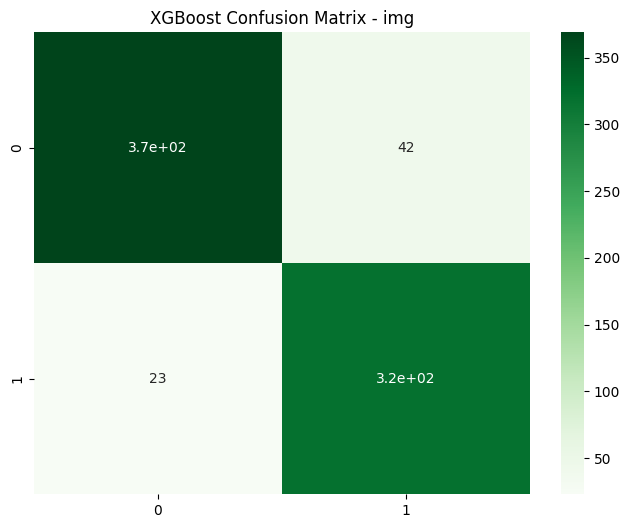

,precision,recall,f1-score,support
0,0.897810,0.941327,0.919054,392.000000
1,0.932749,0.883657,0.907539,361.000000
accuracy,0.913679,0.913679,0.913679,0.913679
macro avg,0.915279,0.912492,0.913296,753.000000
weighted avg,0.914560,0.913679,0.913533,753.000000


In [62]:
Xtrain, Xtest, ytrain, ytest = train_test_split(image2, target.values.ravel(), test_size=.2)

xgbimg = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1, subsample=1, max_depth =3, gamma=5, colsample_bytree=1)

xgbimg.fit(Xtrain,ytrain)

ypred_xgbimg = xgbimg.predict(Xtest)

conf_xgbimg = confusion_matrix(ypred_xgbimg, ytest)

plt.figure(figsize= (8,6))
sns.heatmap(conf_xgbimg, annot=True, cmap = 'Greens')
plt.title(f'XGBoost Confusion Matrix - img')
plt.savefig(f'images/xgb-confusion-img.png')
plt.show()

xgbimg_classificationreport = pd.DataFrame(classification_report(ytest, ypred_xgbimg, output_dict = True)).transpose()
xgbimg_classificationreport